<a href="https://colab.research.google.com/github/kodai-utsunomiya/memorization-and-generalization/blob/main/numerical_experiments/1_reimplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データセット

In [1]:
import numpy as np
import torch

class BinaryDataset:
    def __init__(self, n, k, train_size, test_size, data_seed, normalize=False, device=None):
        """
        BinaryDatasetクラスのコンストラクタ

        Parameters:
        - n: バイナリ文字列の長さ
        - k: 出力ラベルの計算に使用する最初の k 個のビット
        - train_size: 訓練データのサイズ
        - test_size: テストデータのサイズ
        - data_seed: ランダムシード
        - normalize: データを正規化するかどうかを示すフラグ
        - device: データを移動するデバイス
        """
        self.n = n
        self.k = k
        self.train_size = train_size
        self.test_size = test_size
        self.data_seed = data_seed
        self.normalize = normalize
        self.device = device

        # データの準備
        (self.train_inputs, self.train_outputs), (self.test_inputs, self.test_outputs) = self._prepare_data()

    def _prepare_data(self):
        """
        データの準備を行うメソッド

        Returns:
        - tuple: ((訓練データのx, 訓練データのy), (テストデータのx, テストデータのy))
        """
        np.random.seed(self.data_seed)
        total_size = self.train_size + self.test_size

        # ユニークなバイナリ文字列を生成
        binary_strings = {tuple(np.random.randint(2, size=self.n)) for _ in range(total_size)}
        while len(binary_strings) < total_size:
            binary_strings.add(tuple(np.random.randint(2, size=self.n)))

        binary_strings = list(binary_strings)
        inputs = np.array(binary_strings, dtype=np.float32)
        outputs = np.sum(inputs[:, :self.k], axis=-1) % 2

        # # 出力ラベルを 0 -> -1, 1 -> 1 に変換（ヒンジ損失用）
        # outputs = 2 * outputs - 1

        # データの正規化を行う場合
        if self.normalize:
            # 中心化（平均を0に）
            inputs = (inputs - inputs.mean(axis=0))
            # 標準化（各サンプルのノルムで割る）．データが単位ノルムを持つようにスケーリング
            norm = np.linalg.norm(inputs, axis=1, keepdims=True)
            inputs = (inputs / np.maximum(norm, 1e-8))  # ゼロ除算防止

        # インデックスをシャッフルして訓練データとテストデータを分割
        indices = np.random.permutation(total_size)
        train_indices, test_indices = indices[:self.train_size], indices[self.train_size:]

        # NumPy配列からPyTorchテンソルに変換，デバイスに移動
        train_inputs = torch.tensor(inputs[train_indices], dtype=torch.float32).to(self.device)
        train_outputs = torch.tensor(outputs[train_indices], dtype=torch.float32).to(self.device)
        test_inputs = torch.tensor(inputs[test_indices], dtype=torch.float32).to(self.device)
        test_outputs = torch.tensor(outputs[test_indices], dtype=torch.float32).to(self.device)

        return (train_inputs, train_outputs), (test_inputs, test_outputs)

    def get_data(self):
        """
        データセットを取得するメソッド

        Returns:
        - tuple: ((訓練データのx, 訓練データのy), (テストデータのx, テストデータのy))
        """
        return (self.train_inputs, self.train_outputs), (self.test_inputs, self.test_outputs)

# モデル $f(\boldsymbol{x})$

In [2]:
import functools
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

"""
全結合ネットワーク（Fully Connected Network, FC）のクラスを定義．
任意の層数 L を持ち，各層のユニット数は h で指定．
活性化関数 act は任意に指定可能で，バイアス項の有無も指定可能．
"""

class FC(nn.Module):
    def __init__(self, d, h, L, act, bias=False):
        super().__init__()

        # ネットワークの初期化
        hh = d  # 入力の次元数
        for i in range(L):
            # 隠れ層の重み行列を正規分布で初期化
            W = torch.randn(h, hh)

            # メモリ効率を考慮し，重み行列を部分行列に分割して ParameterList に格納
            # next two line are here to avoid memory issue when computing the kerne
            n = max(1, 128 * 256 // hh)  # 分割サイズを計算
            W = nn.ParameterList([nn.Parameter(W[j: j+n]) for j in range(0, len(W), n)])

            # 分割した重み行列をレイヤーとして登録
            setattr(self, "W{}".format(i), W)

            # バイアス項が指定されている場合は，それをゼロで初期化して登録
            if bias:
                self.register_parameter("B{}".format(i), nn.Parameter(torch.zeros(h)))

            # 次のレイヤーの入力次元は現在の隠れ層のユニット数になる
            hh = h

        # 最終層の重み行列を初期化（出力がスカラー値なので次元は (1, h)）
        self.register_parameter("W{}".format(L), nn.Parameter(torch.randn(1, hh)))

        # バイアス項が指定されている場合は，最終層のバイアスをゼロで初期化
        if bias:
            self.register_parameter("B{}".format(L), nn.Parameter(torch.zeros(1)))

        # クラス変数としてレイヤー数，活性化関数，バイアスの有無を保持
        self.L = L
        self.act = act
        self.bias = bias

    def forward(self, x):
        # 順伝播計算
        for i in range(self.L + 1):
            # i 番目の層の重み行列を取得
            W = getattr(self, "W{}".format(i))

            # ParameterList 形式の重み行列をフルの行列に結合
            if isinstance(W, nn.ParameterList):
                W = torch.cat(list(W))

            # バイアス項が指定されている場合は，バイアスを取得
            if self.bias:
                B = self.bias * getattr(self, "B{}".format(i))
            else:
                B = 0

            # 現在の入力の次元数を取得
            h = x.size(1)

            if i < self.L:
                # 隠れ層での線形変換とスケーリング，そして活性化関数の適用
                x = x @ (W.t() / h ** 0.5)  # 重み行列との積（次元スケーリング）
                x = self.act(x + B)  # バイアス項を加えた後，活性化関数を適用
            else:
                # 最終層での線形変換（出力はスカラー値）
                x = x @ (W.t() / h ** 0.5) + B  # スカラー出力

        # 出力を 1 次元のテンソルに変換して返す
        return x.view(-1)

# 保存管理

In [3]:
class Saver:
    def __init__(self, hyper):
        self.hyper = hyper
        self.checkpoint_dir = hyper.checkpoint_dir
        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)

    def save_hyperparameters(self):
        hyper_params = {attr: getattr(self.hyper, attr) for attr in dir(self.hyper) if not attr.startswith('__')}
        hyper_file = os.path.join(self.checkpoint_dir, 'hyperparameters.json')
        with open(hyper_file, 'w') as f:
            json.dump(hyper_params, f, indent=4)

    def save_metrics(self, metrics):
        result_dir = os.path.join(self.checkpoint_dir, 'Result')
        if not os.path.exists(result_dir):
            os.makedirs(result_dir)

        metrics_file = os.path.join(result_dir, 'metrics.json')
        with open(metrics_file, 'w') as f:
            json.dump(metrics, f, indent=4)

    def save_model_parameters(self, model, step):
        model_params_dir = os.path.join(self.checkpoint_dir, 'Result', 'Model_Parameters')
        if not os.path.exists(model_params_dir):
            os.makedirs(model_params_dir)

        model_params_file = os.path.join(model_params_dir, f'model_params_step_{step}.pt')
        torch.save(model.state_dict(), model_params_file)

In [6]:
class Saver:
    def __init__(self, hyper):
        self.hyper = hyper
        self.checkpoint_dir = hyper.checkpoint_dir
        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)

    def save_hyperparameters(self):
        hyper_params = vars(self.hyper)
        with open(os.path.join(self.checkpoint_dir, 'hyperparameters.json'), 'w') as f:
            json.dump(hyper_params, f, indent=4)

    def save_metrics(self, metrics):
        with open(os.path.join(self.checkpoint_dir, 'metrics.json'), 'w') as f:
            json.dump(metrics, f, indent=4)

    def save_model_parameters(self, model, step):
        torch.save(model.state_dict(), os.path.join(self.checkpoint_dir, f'model_{step}.pt'))

    def save_ntk_matrices(self, ktrtr, ktetr, ktete, step):
        torch.save({'ktrtr': ktrtr, 'ktetr': ktetr, 'ktete': ktete}, os.path.join(self.checkpoint_dir, f'ntk_matrices_{step}.pt'))

# 損失関連

In [7]:
class LossFunctions:
    def __init__(self, model, weight_decay, reg_type=None, alpha=1.0, f0=False):
        self.model = model
        self.weight_decay = weight_decay
        self.reg_type = reg_type
        self.alpha = alpha
        self.f0 = f0

        # 学習開始時のモデルパラメータを保存
        if self.f0:
            self.initial_params = {name: param.clone() for name, param in self.model.named_parameters()}
        else:
            self.initial_params = None

    def binary_cross_entropy_with_logits(self, outputs, targets):
        sigmoid_outputs = torch.sigmoid(outputs)
        bce_loss = - (targets * torch.log(sigmoid_outputs + 1e-10) + (1 - targets) * torch.log(1 - sigmoid_outputs + 1e-10))
        return bce_loss.mean()

    def hinge_embedding_loss(self, outputs, targets):
        targets = 2 * targets - 1  # Convert 0/1 labels to -1/1
        hinge_loss = torch.clamp(1 - targets * outputs, min=0)
        return hinge_loss.mean()

    def mean_squared_error(self, outputs, targets):
        mse_loss = torch.mean((outputs - targets) ** 2)
        return mse_loss

    def regularization_loss(self):
        if self.reg_type is None:
            return 0
        elif self.reg_type == 'l1':
            return self.weight_decay * sum(param.abs().sum() for param in self.model.parameters())
        elif self.reg_type == 'l2':
            return self.weight_decay * sum(param.pow(2.0).sum() for param in self.model.parameters())
        else:
            raise ValueError('Unknown regularization type')

    def compute_loss(self, loss_fn_name, outputs, targets, inputs=None):
        if self.f0:
            if inputs is None:
                raise ValueError('Inputs must be provided when f0 is True')

            # 初期パラメータでの出力を計算
            initial_outputs = self._compute_model_outputs(self.initial_params, inputs)

            # 損失関数の計算
            if loss_fn_name == 'cross_entropy':
                loss = self.binary_cross_entropy_with_logits(self.alpha * (outputs - initial_outputs), targets)
            elif loss_fn_name == 'hinge':
                loss = self.hinge_embedding_loss(self.alpha * (outputs - initial_outputs), targets)
            elif loss_fn_name == 'mse':
                loss = self.mean_squared_error(self.alpha * (outputs - initial_outputs), targets)
            else:
                raise ValueError('Unknown loss function')

        else:
            # f0 が False の場合の損失関数
            if loss_fn_name == 'cross_entropy':
                loss = self.binary_cross_entropy_with_logits(outputs, targets)
            elif loss_fn_name == 'hinge':
                loss = self.hinge_embedding_loss(outputs, targets)
            elif loss_fn_name == 'mse':
                loss = self.mean_squared_error(outputs, targets)
            else:
                raise ValueError('Unknown loss function')

        return loss + self.regularization_loss()

    def _compute_model_outputs(self, params, inputs):
        # 初期パラメータでモデルの出力を計算するヘルパー関数
        with torch.no_grad():
            old_params = {name: param.clone() for name, param in self.model.named_parameters()}
            for name, param in params.items():
                self.model.state_dict()[name].copy_(param)
            outputs = self.model(inputs)
            # パラメータを元に戻す
            for name, param in old_params.items():
                self.model.state_dict()[name].copy_(param)
        return outputs

# カーネルの計算

### `compute_kernels` メソッド

1. **カーネル行列の定義**:

   訓練データ $ X_{\text{tr}} $ とテストデータ $ X_{\text{te}} $ がそれぞれ $ N_{\text{tr}} $ 個と $ N_{\text{te}} $ 個のサンプルを含むとする．
   
   モデルのパラメータは $ \theta $ とし，これをグループに分割して処理．

   定義するカーネル行列：
   
   * $ K_{\text{trtr}} \in \mathbb{R}^{N_{\text{tr}} \times N_{\text{tr}}} $

   * $ K_{\text{tetr}} \in \mathbb{R}^{N_{\text{te}} \times N_{\text{tr}}} $

   * $ K_{\text{tete}} \in \mathbb{R}^{N_{\text{te}} \times N_{\text{te}}} $

<br>

2. **勾配計算**:
   
   訓練データ $ x_{\text{tr}}^{(i)} $ に対する勾配を $ J_{\text{tr}} $ とし，テストデータ $ x_{\text{te}}^{(j)} $ に対する勾配を $ J_{\text{te}} $ とする．

   訓練データに対するヤコビ行列 $ J_{\text{tr}} $ の成分：
   
   - $ J_{\text{tr}}^{(i, k)} = \frac{\partial f(x_{\text{tr}}^{(i)}; \theta)}{\partial \theta_k} $

      ここで $ f(x; \theta) $ はモデルの出力，$\theta_k$ はモデルのパラメータの $ k $-th 要素．

   テストデータに対するヤコビ行列 $ J_{\text{te}} $ の成分：

   - $ J_{\text{te}}^{(j, k)} = \frac{\partial f(x_{\text{te}}^{(j)}; \theta)}{\partial \theta_k} $

<br>

3. **カーネル行列の計算**:
   
   訓練データ間のカーネル行列 $ K_{\text{trtr}} $ は，訓練データのヤコビ行列 $ J_{\text{tr}} $ の内積：

    - $ K_{\text{trtr}} = J_{\text{tr}} J_{\text{tr}}^T $

     ここで $ J_{\text{tr}} $ のサイズは $ N_{\text{tr}} \times D $ で，$ D $ はパラメータの次元数．

   テストデータと訓練データ間のカーネル行列 $ K_{\text{tetr}} $ は，テストデータのヤコビ行列 $ J_{\text{te}} $ と訓練データのヤコビ行列 $ J_{\text{tr}} $ の内積：

    - $ K_{\text{tetr}} = J_{\text{te}} J_{\text{tr}}^T $

   テストデータ間のカーネル行列 $ K_{\text{tete}} $ は，テストデータのヤコビ行列 $ J_{\text{te}} $ の内積：

    - $ K_{\text{tete}} = J_{\text{te}} J_{\text{te}}^T $

In [51]:
import torch

class NTK:
    def __init__(self, model):
        self.model = model

    def gradient(self, outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
        '''
        `outputs` に対する `inputs` の勾配を計算する関数
        '''
        # `inputs` がテンソルの場合はリストに変換
        if torch.is_tensor(inputs):
            inputs = [inputs]

        # `torch.autograd.grad` 関数を使用して勾配を計算
        grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                    allow_unused=True,  # 計算に使用されないテンソルには勾配が計算されない
                                    retain_graph=retain_graph,  # 計算グラフを保持するかどうか
                                    create_graph=create_graph)  # 勾配の計算グラフを作成するかどうか

        # 勾配が None の場合は，同じサイズのゼロテンソルを代わりに使用
        grads = [g if g is not None else torch.zeros_like(inp) for g, inp in zip(grads, inputs)]

        # 勾配テンソルをフラットな形状に変換して連結
        return torch.cat([g.contiguous().view(-1) for g in grads])

    def compute_kernels(self, xtr, xte):
        '''
        モデルのカーネル行列を計算する関数

        :param xtr: 訓練データ
        :param xte: テストデータ
        :return: 訓練データ間，テストデータと訓練データ間，テストデータ間のカーネル行列
        '''
        len_xtr, len_xte = len(xtr), len(xte)

        # カーネル行列の初期化
        ktrtr = xtr.new_zeros(len_xtr, len_xtr)  # 訓練データ間のカーネル行列
        ktetr = xtr.new_zeros(len_xte, len_xtr)  # テストデータと訓練データ間のカーネル行列
        ktete = xtr.new_zeros(len_xte, len_xte)  # テストデータ間のカーネル行列

        # モデルのパラメータをサイズで降順にソートし，メモリ制限に基づいて分割
        params = [p for p in sorted(self.model.parameters(), key=lambda p: p.numel(), reverse=True)]
        split_size = 2e9 // (8 * (len_xtr + len_xte))  # メモリ制限を計算

        # パラメータをメモリ制限に基づいて分割
        param_groups = []
        current_group = []
        current_size = 0
        for p in params:
            param_size = p.numel()
            if current_size + param_size > split_size:
                if current_group:
                    param_groups.append(current_group)
                current_group = [p]
                current_size = param_size
            else:
                current_group.append(p)
                current_size += param_size
        if current_group:
            param_groups.append(current_group)

        # 各パラメータグループについてカーネル行列を計算
        for i, group in enumerate(param_groups):
            # print(f"[{i}/{len(param_groups)}] [len={len(group)} numel={sum(p.numel() for p in group)}]", flush=True)
            print("##########  Computing NTK matrices...  ##########")

            # 勾配行列を初期化
            jtr = xtr.new_empty(len_xtr, sum(p.numel() for p in group))  # 訓練データに対する勾配行列
            jte = xte.new_empty(len_xte, sum(p.numel() for p in group))  # テストデータに対する勾配行列

            # 訓練データに対する勾配行列を計算
            for j, x in enumerate(xtr):
                jtr[j] = self.gradient(self.model(x[None]), group)  # 勾配計算

            # テストデータに対する勾配行列を計算
            for j, x in enumerate(xte):
                jte[j] = self.gradient(self.model(x[None]), group)  # 勾配計算

            # カーネル行列を更新
            ktrtr.add_(jtr @ jtr.t())  # 訓練データ間のカーネル行列を更新
            ktetr.add_(jte @ jtr.t())  # テストデータと訓練データ間のカーネル行列を更新
            ktete.add_(jte @ jte.t())  # テストデータ間のカーネル行列を更新

        return ktrtr, ktetr, ktete

# 設定と実行

In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import json

"""
定義済み：
・class BinaryDataset
・class FC(nn.Module)
・class LossFunctions
・class Saver
・class NTK
"""

# 設定
class HyperParams:
    def __init__(self):
        self.init_seed = 0
        ## データ
        self.n = 30
        self.k = 3
        self.train_size = 500
        self.test_size = 1000
        self.normalize = False
        self.data_seed = 0
        ## モデル
        self.alpha = 2 ** (-3)  ## メモ：大きな alpha のとき（例：2 ** 3），学習後のパラメータが 0 に近かった
        self.f0 = True  # True のとき，F(x) = alpha * (f - f0) という形のモデルの学習を行う
        self.layer = 3
        self.hidden_size = 50
        self.act = 'relu'
        self.bias = True
        ## 学習
        self.loss_fn = 'cross_entropy'
        self.optimizer = 'adam'
        self.b1 = .99
        self.b2 = .98
        self.learning_rate = 0.006
        self.regularization = 'l1'  # 'l1', 'l2', or None
        self.weight_decay = 2e-05
        self.max_steps = 4500
        self.batch_seed = 0
        self.batch_size = self.train_size
        ## 計算
        self.compute_ntk = True
        ## 保存
        self.log_every = 1
        self.save_every = 100
        self.checkpoint_dir = 'test01'

# 活性化関数取得
def get_activation(act_name):
    if act_name == 'relu':
        return lambda x: 2 ** 0.5 * torch.relu(x)
    elif act_name == 'tanh':
        return torch.tanh
    else:
        raise ValueError('act not specified')

# オプティマイザ取得
def get_optimizer(optimizer_name, model, hyper):
    if optimizer_name == 'sgd':
        return optim.SGD(model.parameters(), lr=hyper.learning_rate)
    elif optimizer_name == 'vanilla_gd':
        return None
    elif optimizer_name == 'adam':
        return optim.Adam(model.parameters(), lr=hyper.learning_rate, betas=[hyper.b1, hyper.b2])
    elif optimizer_name == 'adamw':
        return optim.AdamW(model.parameters(), lr=hyper.learning_rate, weight_decay=hyper.weight_decay)
    else:
        return ValueError('optim not specified')

# トレーニングステップ
def train_step(model, optimizer, loss_fn, xtr, ytr, hyper):
    model.train()

    torch.manual_seed(hyper.batch_seed)

    # ミニバッチ処理
    indices = torch.randperm(len(xtr))
    batch_indices = indices[:hyper.batch_size]

    xb = xtr[batch_indices]
    yb = ytr[batch_indices]

    if optimizer:
        optimizer.zero_grad()

    outputs = model(xb)
    inputs = xb if hyper.f0 else None
    loss = loss_fn.compute_loss(hyper.loss_fn, outputs, yb.float(), inputs=inputs)

    if optimizer:
        loss.backward()
        optimizer.step()
    else:
        # Vanilla GDの場合，手動で勾配を計算してパラメータを更新
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param -= hyper.learning_rate * param.grad

    preds = torch.sigmoid(outputs) > 0.5
    accuracy = (preds.int() == yb.int()).float().mean().item()

    return loss.item(), accuracy

# 評価ステップ
def eval_step(model, loss_fn, x, y, hyper):
    model.eval()
    with torch.no_grad():
        outputs = model(x)
        loss = loss_fn.compute_loss(hyper.loss_fn, outputs, y.float(), inputs=x)
        preds = torch.sigmoid(outputs) > 0.5
        accuracy = (preds.int() == y.int()).float().mean().item()

    return loss.item(), accuracy

# トレーニングループ
def train_loop(hyper, model, optimizer, loss_fn, xtr, ytr, xte, yte):
    saver = Saver(hyper)
    ntk_calculator = NTK(model) if hyper.compute_ntk else None
    all_metrics = []

    # NTKを必ず計算するステップ
    ntk_steps = {1, 3, 5, 10, 30, 60, 100}

    # ハイパーパラメータを保存
    saver.save_hyperparameters()

    # 学習前のモデル状態と NTK 行列を保存
    initial_metrics = {
        'step': 0,
        'train_loss': None,
        'train_acc': None,
        'eval_loss': None,
        'eval_acc': None,
        'l1_norm': sum(param.abs().sum().item() for param in model.parameters()),
        'l2_norm': np.sqrt(sum(param.pow(2.0).sum().item() for param in model.parameters())),
        'ntk_change': None
    }
    if hyper.compute_ntk and ntk_calculator:
        initial_ktrtr, initial_ktetr, initial_ktete = ntk_calculator.compute_kernels(xtr, xte)
        initial_ntk = {
            'ktete': initial_ktete,
            'ktrtr': initial_ktrtr,
            'ktetr': initial_ktetr
        }
    all_metrics.append(initial_metrics)
    saver.save_metrics(all_metrics)

    for step in range(1, hyper.max_steps + 1):
        train_loss, train_acc = train_step(model, optimizer, loss_fn, xtr, ytr, hyper)

        if step % hyper.log_every == 0:
            eval_loss, eval_acc = eval_step(model, loss_fn, xte, yte, hyper)
            l1_norm = sum(param.abs().sum().item() for param in model.parameters())
            l2_norm = np.sqrt(sum(param.pow(2.0).sum().item() for param in model.parameters()))
            metrics = {
                'step': step,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'eval_loss': eval_loss,
                'eval_acc': eval_acc,
                'l1_norm': l1_norm,
                'l2_norm': l2_norm,
                'ntk_change': None
            }
            all_metrics.append(metrics)

            print(f"Step {step}/{hyper.max_steps}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Eval Loss = {eval_loss:.4f}, Eval Acc = {eval_acc:.4f}")

        # 指定されたステップ（1, 3, 5, 10, 30, 60, 100）または save_every に従って NTK を計算
        if step % hyper.save_every == 0 or step in ntk_steps:
            # 学習メトリクスを保存
            saver.save_metrics(all_metrics)
            # モデルのパラメータを保存
            saver.save_model_parameters(model, step)
            # NTK 行列を計算して保存
            if hyper.compute_ntk and ntk_calculator:
                ktrtr, ktetr, ktete = ntk_calculator.compute_kernels(xtr, xte)
                saver.save_ntk_matrices(ktrtr, ktetr, ktete, step)
                ntk_change = {
                    'ktete': torch.norm(ktete - initial_ntk['ktete']).item() / torch.norm(initial_ntk['ktete']).item(),
                    'ktrtr': torch.norm(ktrtr - initial_ntk['ktrtr']).item() / torch.norm(initial_ntk['ktrtr']).item(),
                    'ktetr': torch.norm(ktetr - initial_ntk['ktetr']).item() / torch.norm(initial_ntk['ktetr']).item()
                }
                all_metrics[-1]['ntk_change'] = ntk_change

        # NTKの変化を記録するためにメトリクスを保存
        if step % hyper.save_every == 0 and hyper.compute_ntk:
            saver.save_metrics(all_metrics)

##### 実行
hyper = HyperParams()
torch.manual_seed(hyper.init_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# データセット
dataset = BinaryDataset(hyper.n, hyper.k, hyper.train_size, hyper.test_size, hyper.data_seed, hyper.normalize, device)
(xtr, ytr), (xte, yte) = dataset.get_data()

# モデルを作成
act = get_activation(hyper.act)
model = FC(hyper.n, hyper.hidden_size, hyper.layer, act, bias=hyper.bias).to(device)

# 損失関数とオプティマイザ
loss_fn = LossFunctions(model, hyper.weight_decay, hyper.regularization, alpha=hyper.alpha, f0=hyper.f0)
optimizer = get_optimizer(hyper.optimizer, model, hyper)

# 訓練実行
train_loop(hyper, model, optimizer, loss_fn, xtr, ytr, xte, yte)

Using device: cpu
##########  Computing NTK matrices...  ##########
Step 1/4500: Train Loss = 0.7977, Train Acc = 0.5160, Eval Loss = 0.7976, Eval Acc = 0.5200
##########  Computing NTK matrices...  ##########
Step 2/4500: Train Loss = 0.7962, Train Acc = 0.5800, Eval Loss = 0.7975, Eval Acc = 0.5270
Step 3/4500: Train Loss = 0.7948, Train Acc = 0.5960, Eval Loss = 0.7975, Eval Acc = 0.5100
##########  Computing NTK matrices...  ##########
Step 4/4500: Train Loss = 0.7935, Train Acc = 0.6020, Eval Loss = 0.7976, Eval Acc = 0.5110
Step 5/4500: Train Loss = 0.7924, Train Acc = 0.5800, Eval Loss = 0.7976, Eval Acc = 0.5030
##########  Computing NTK matrices...  ##########
Step 6/4500: Train Loss = 0.7912, Train Acc = 0.5680, Eval Loss = 0.7976, Eval Acc = 0.5060
Step 7/4500: Train Loss = 0.7900, Train Acc = 0.5660, Eval Loss = 0.7976, Eval Acc = 0.4990
Step 8/4500: Train Loss = 0.7889, Train Acc = 0.5640, Eval Loss = 0.7976, Eval Acc = 0.5010
Step 9/4500: Train Loss = 0.7878, Train Acc = 

### 損失，精度，ノルムの変化

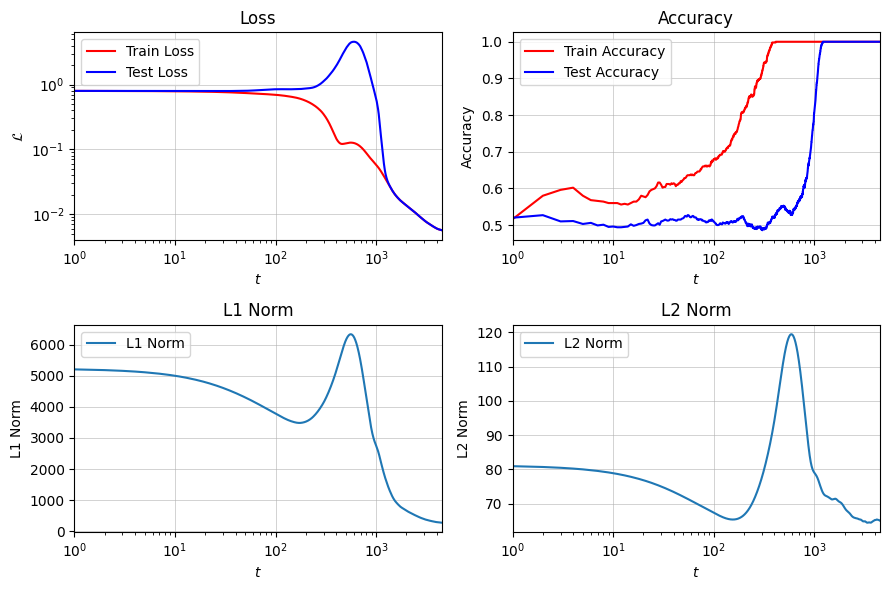

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import os
import json

def load_metrics(checkpoint_dir):
    # metrics.jsonの読み込み
    metrics_file = os.path.join(checkpoint_dir, 'metrics.json')
    if not os.path.exists(metrics_file):
        raise FileNotFoundError('No metrics file found.')

    with open(metrics_file, 'r') as f:
        metrics = json.load(f)

    return metrics

def plot_metrics(metrics):
    steps = [entry['step'] for entry in metrics]
    train_losses = [entry['train_loss'] for entry in metrics]
    eval_losses = [entry['eval_loss'] for entry in metrics]
    train_accuracies = [entry['train_acc'] for entry in metrics]
    eval_accuracies = [entry['eval_acc'] for entry in metrics]
    l1_norms = [entry['l1_norm'] for entry in metrics]
    l2_norms = [entry['l2_norm'] for entry in metrics]

    plt.figure(figsize=(9, 6))

    # 損失
    plt.subplot(2, 2, 1)
    plt.plot(steps, train_losses, label='Train Loss', color='red')
    plt.plot(steps, eval_losses, label='Test Loss', color='blue')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1, max(steps)+1)
    plt.xlabel('$t$')
    plt.ylabel('$\mathcal{L}$')
    plt.title('Loss')
    plt.grid(True, linestyle='-', linewidth=0.4)
    plt.legend()

    # 精度
    plt.subplot(2, 2, 2)
    plt.plot(steps, train_accuracies, label='Train Accuracy', color='red')
    plt.plot(steps, eval_accuracies, label='Test Accuracy', color='blue')
    plt.xscale('log')
    plt.xlim(1, max(steps)+1)
    plt.xlabel('$t$')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.grid(True, linestyle='-', linewidth=0.4)
    plt.legend()

    # L1 Norm
    plt.subplot(2, 2, 3)
    plt.plot(steps, l1_norms, label='L1 Norm')
    plt.xscale('log')
    plt.xlim(1, max(steps)+1)
    plt.xlabel('$t$')
    plt.ylabel('L1 Norm')
    plt.title('L1 Norm')
    plt.grid(True, linestyle='-', linewidth=0.4)
    plt.legend()

    # L2 Norm
    plt.subplot(2, 2, 4)
    plt.plot(steps, l2_norms, label='L2 Norm')
    plt.xscale('log')
    plt.xlim(1, max(steps)+1)
    plt.xlabel('$t$')
    plt.ylabel('L2 Norm')
    plt.title('L2 Norm')
    plt.grid(True, linestyle='-', linewidth=0.4)
    plt.legend()

    plt.tight_layout()
    plt.show()


checkpoint_dir = 'test01'
metrics = load_metrics(checkpoint_dir)
plot_metrics(metrics)

### NTK 行列の変化

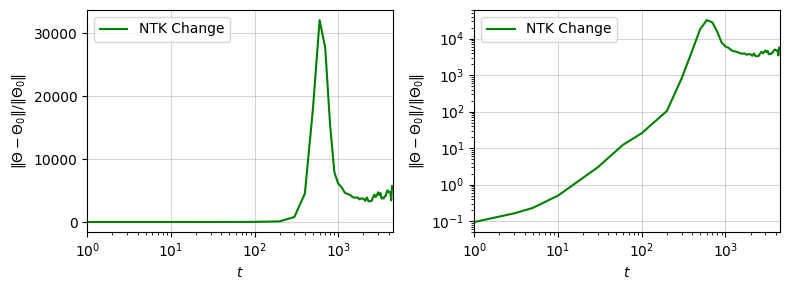

In [139]:
import matplotlib.pyplot as plt
import json
import os

def load_metrics_from_last_result_dir(checkpoint_dir):
    # metrics.jsonの読み込み
    metrics_file = os.path.join(checkpoint_dir, 'metrics.json')
    if not os.path.exists(metrics_file):
        raise FileNotFoundError('No metrics file found.')

    with open(metrics_file, 'r') as f:
        metrics = json.load(f)

    return metrics

def plot_ntk_change(metrics):
    steps = []
    ktete_changes = []

    for entry in metrics:
        if entry.get('ntk_change') is not None:
            ntk_change = entry['ntk_change']
            if isinstance(ntk_change, dict):
                ktete_changes.append(ntk_change.get('ktete', None))
            else:
                # ntk_change が辞書でない場合
                ktete_changes.append(None)
            steps.append(entry['step'])

    if not steps:
        print("No NTK change data found.")
        return

    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    # 通常スケール
    axs[0].plot(steps, ktete_changes, label='NTK Change', color='green')
    axs[0].set_xscale('log')
    axs[0].set_xlim(1, max(steps) + 1)
    axs[0].set_xlabel('$t$')
    axs[0].set_ylabel('$\|\Theta - \Theta_0\| / \|\Theta_0\|$')
    # axs[0].set_title('Relative evolution of the $\Theta(w, x_{\mathrm{test}}, x_{\mathrm{test}})$')
    axs[0].grid(True, linestyle='-', linewidth=0.4)
    axs[0].legend()

    # 対数スケール
    axs[1].plot(steps, ktete_changes, label='NTK Change', color='green')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlim(1, max(steps) + 1)
    axs[1].set_xlabel('$t$')
    axs[1].set_ylabel('$\|\Theta - \Theta_0\| / \|\Theta_0\|$')
    # axs[1].set_title('Relative evolution of the $\Theta(w, x_{\mathrm{test}}, x_{\mathrm{test}})$')
    axs[1].grid(True, linestyle='-', linewidth=0.4)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

checkpoint_dir = 'test01'
metrics = load_metrics_from_last_result_dir(checkpoint_dir)
plot_ntk_change(metrics)

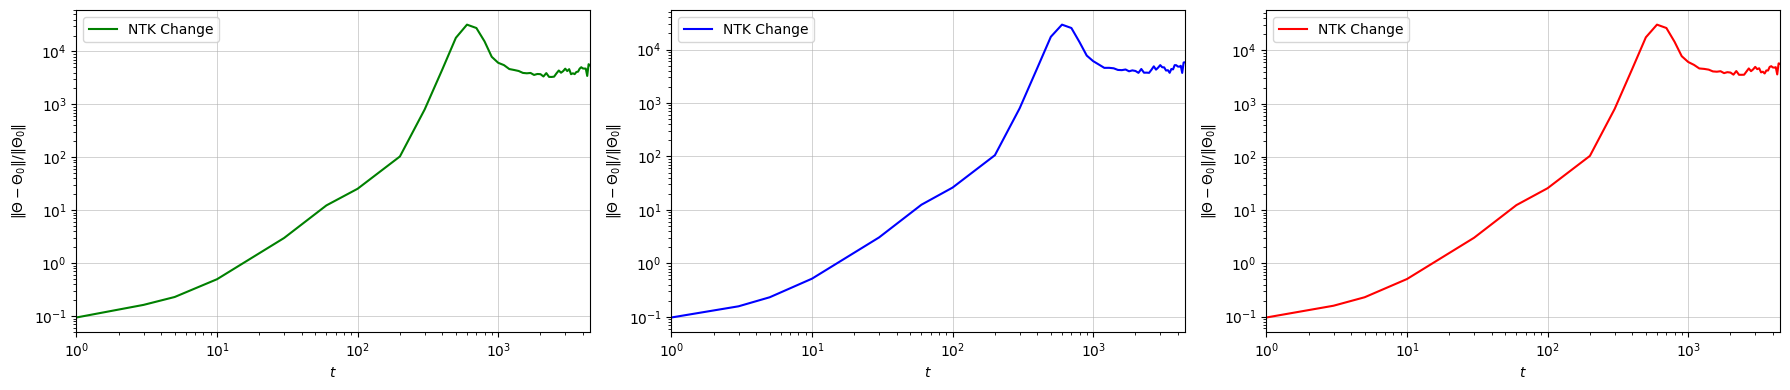

In [145]:
def plot_ntk_change(metrics):
    steps = []
    ktete_changes = []
    ktrtr_changes = []
    ktrte_changes = []

    for entry in metrics:
        if entry.get('ntk_change') is not None:
            ntk_change = entry['ntk_change']
            if isinstance(ntk_change, dict):
                # 各 ntk_change の値を取得
                ktete_changes.append(ntk_change.get('ktete', None))
                ktrtr_changes.append(ntk_change.get('ktrtr', None))
                ktrte_changes.append(ntk_change.get('ktetr', None))
            else:
                # ntk_change が辞書でない場合
                ktete_changes.append(None)
                ktrtr_changes.append(None)
                ktrte_changes.append(None)
            steps.append(entry['step'])

    if not steps:
        print("No NTK change data found.")
        return

    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # ktete
    axs[0].plot(steps, ktete_changes, label='NTK Change', color='green')
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlim(1, max(steps) + 1)
    axs[0].set_xlabel('$t$')
    axs[0].set_ylabel('$\|\Theta - \Theta_0\| / \|\Theta_0\|$')
    # axs[0].set_title('Relative evolution of the $\Theta(w, x_{\mathrm{test}}, x_{\mathrm{test}})$')
    axs[0].grid(True, linestyle='-', linewidth=0.4)
    axs[0].legend()

    # ktrtr
    axs[1].plot(steps, ktrtr_changes, label='NTK Change', color='blue')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlim(1, max(steps) + 1)
    axs[1].set_xlabel('$t$')
    axs[1].set_ylabel('$\|\Theta - \Theta_0\| / \|\Theta_0\|$')
    # axs[1].set_title('Relative evolution of the $\Theta(w, x_{\mathrm{train}}, x_{\mathrm{train}})$')
    axs[1].grid(True, linestyle='-', linewidth=0.4)
    axs[1].legend()

    # ktetr
    axs[2].plot(steps, ktrte_changes, label='NTK Change', color='red')
    axs[2].set_xscale('log')
    axs[2].set_yscale('log')
    axs[2].set_xlim(1, max(steps) + 1)
    axs[2].set_xlabel('$t$')
    axs[2].set_ylabel('$\|\Theta - \Theta_0\| / \|\Theta_0\|$')
    # axs[2].set_title('Relative evolution of the $\Theta(w, x_{\mathrm{test}}, x_{\mathrm{train}})$')
    axs[2].grid(True, linestyle='-', linewidth=0.4)
    axs[2].legend()

    plt.tight_layout()
    plt.show()

checkpoint_dir = 'test01'
metrics = load_metrics(checkpoint_dir)
plot_ntk_change(metrics)

## 重み行列の可視化

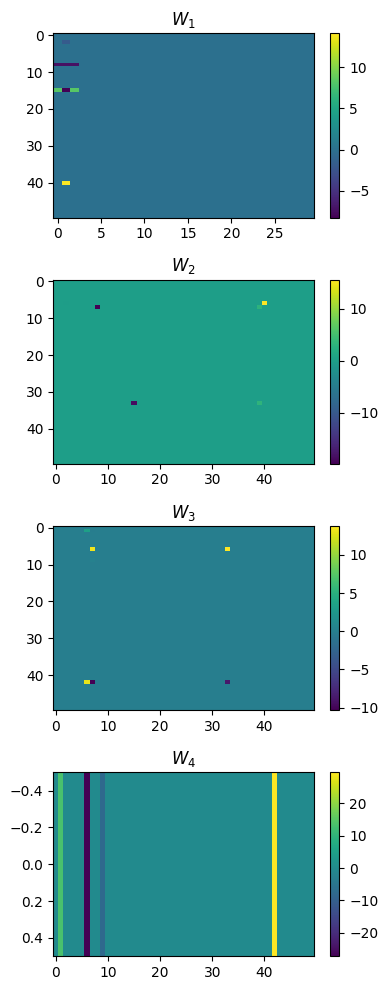

In [106]:
import torch
import matplotlib.pyplot as plt
import os

# パラメータの読み込み
def load_model_parameters(model, checkpoint_dir, step):
    model_params_file = os.path.join(checkpoint_dir, f'model_{step}.pt')
    if not os.path.exists(model_params_file):
        raise FileNotFoundError(f"Model parameters file not found at {model_params_file}")

    model.load_state_dict(torch.load(model_params_file, weights_only=True))

# 重み行列を可視化
def visualize_weights(model):
    layers = [getattr(model, f"W{i}") for i in range(model.L + 1)]

    # `figsize` を層の数に基づいて調整
    width = 4
    height = 2.5 * len(layers)
    fig, axes = plt.subplots(len(layers), 1, figsize=(width, height))

    if len(layers) == 1:
        axes = [axes]

    for i, layer in enumerate(layers):
        if isinstance(layer, nn.ParameterList):
            weights = torch.cat([p.data for p in layer])
        else:
            weights = layer.data

        cax = axes[i].imshow(weights.cpu().numpy(), aspect='auto', cmap='viridis')
        axes[i].set_title(f'$W_{i+1}$', fontsize=12)

        fig.colorbar(cax, ax=axes[i], orientation='vertical')

    plt.tight_layout()
    plt.show()

def main(checkpoint_dir, step):
    # モデルの再構築
    hyper = HyperParams()
    act = get_activation(hyper.act)
    model = FC(hyper.n, hyper.hidden_size, hyper.layer, act, bias=hyper.bias)

    # モデルパラメータのロード
    load_model_parameters(model, checkpoint_dir, step)

    # 重み行列の可視化
    visualize_weights(model)

checkpoint_dir = 'test01'
step = 4400  # 表示する Step を設定

main(checkpoint_dir, step)

## NTK 行列の可視化

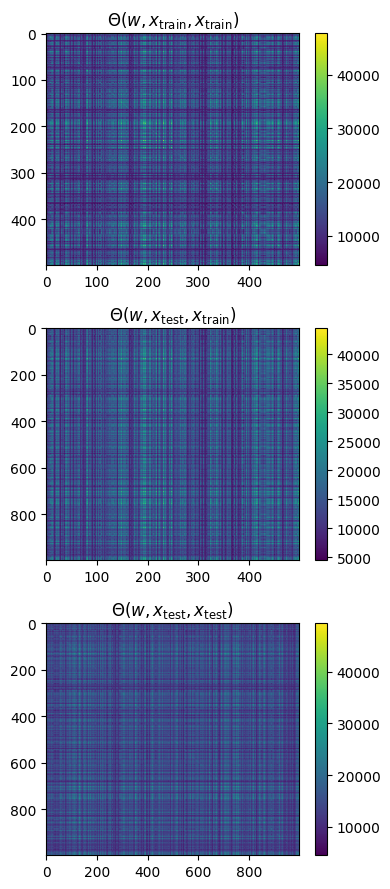

In [107]:
import torch
import matplotlib.pyplot as plt
import os

# NTK 行列をロードする関数
def load_ntk_matrices(checkpoint_dir, step):
    ntk_file = os.path.join(checkpoint_dir, f'ntk_matrices_{step}.pt')
    if not os.path.exists(ntk_file):
        raise FileNotFoundError(f"NTK matrices file not found at {ntk_file}")

    ntk_data = torch.load(ntk_file, weights_only=True)
    return ntk_data['ktrtr'], ntk_data['ktetr'], ntk_data['ktete']

# NTK 行列を可視化する関数
def visualize_ntk_matrices(ktrtr, ktetr, ktete):
    matrices = {'ktrtr': ktrtr, 'ktetr': ktetr, 'ktete': ktete}
    titles = ['$\Theta(w, x_{\mathrm{train}}, x_{\mathrm{train}})$', '$\Theta(w, x_{\mathrm{test}}, x_{\mathrm{train}})$', '$\Theta(w, x_{\mathrm{test}}, x_{\mathrm{test}})$']

    # `figsize` を行列の数に基づいて調整
    width = 4
    height = 3 * len(matrices)
    fig, axes = plt.subplots(len(matrices), 1, figsize=(width, height))

    if len(matrices) == 1:
        axes = [axes]

    for i, (key, matrix) in enumerate(matrices.items()):
        cax = axes[i].imshow(matrix.cpu().numpy(), aspect='auto', cmap='viridis')
        axes[i].set_title(titles[i], fontsize=12)
        fig.colorbar(cax, ax=axes[i], orientation='vertical')

    plt.tight_layout()
    plt.show()

def main(checkpoint_dir, step):
    # NTK 行列のロード
    ktrtr, ktetr, ktete = load_ntk_matrices(checkpoint_dir, step)

    # NTK 行列の可視化
    visualize_ntk_matrices(ktrtr, ktetr, ktete)

checkpoint_dir = 'test01'
step = 4400  # 表示する Step を設定

main(checkpoint_dir, step)

# Numerical Experiments

## 1. $\alpha$ は Lazyness を制御する